# Step Size Analysis (step_size=0.05)

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [3]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [4]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=1.25
expected_alpha=2

## Initialize constants for simulation

In [5]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

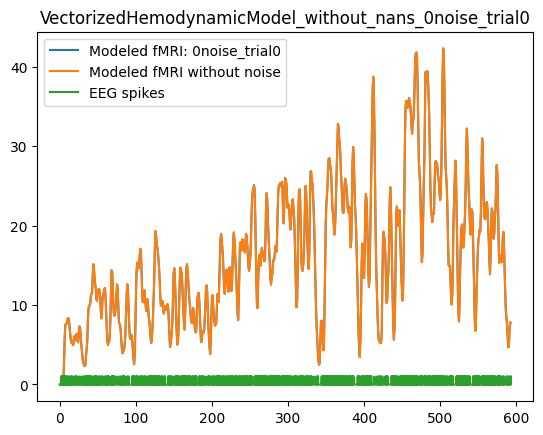

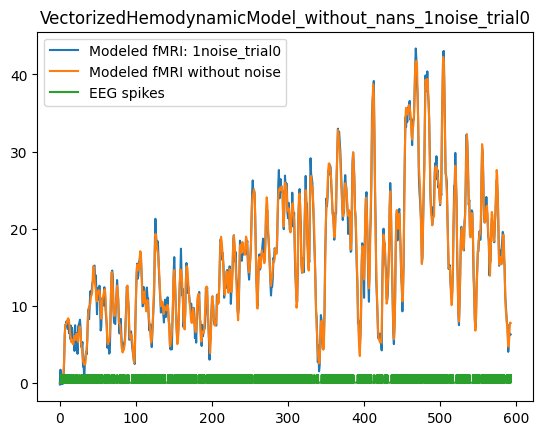

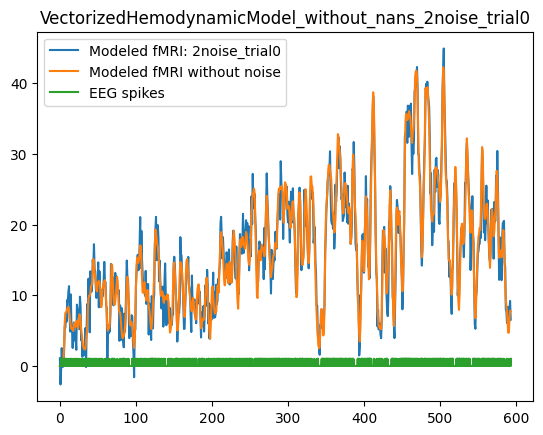

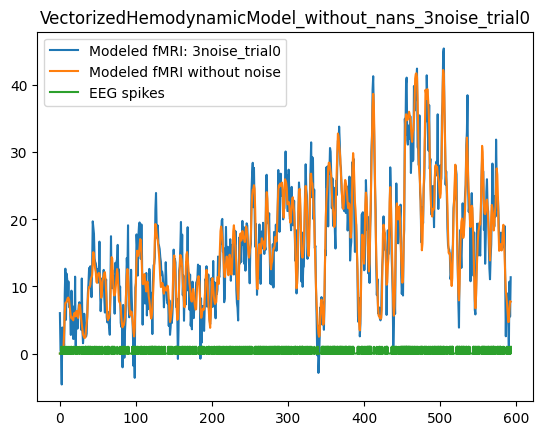

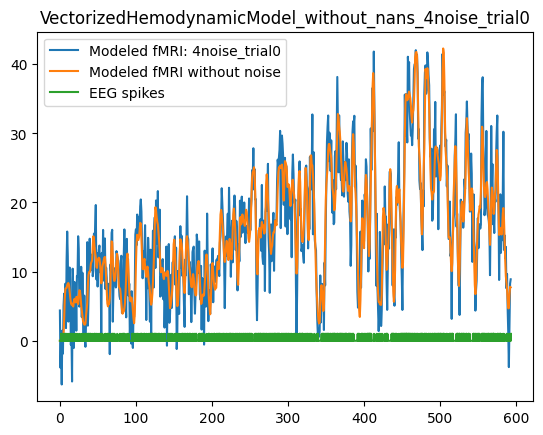

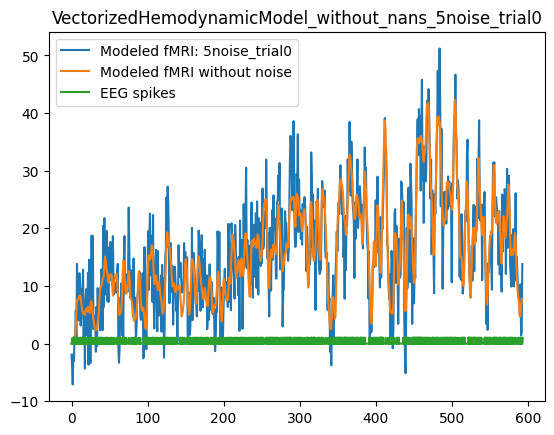

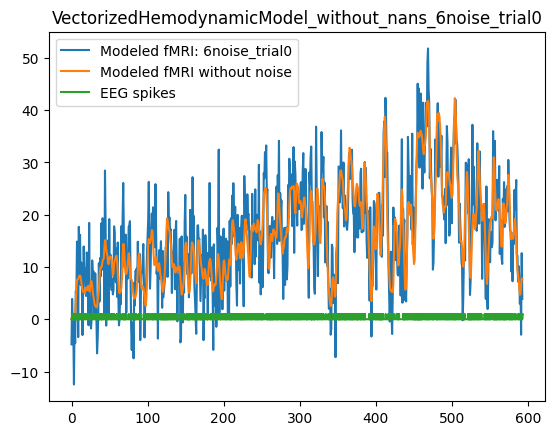

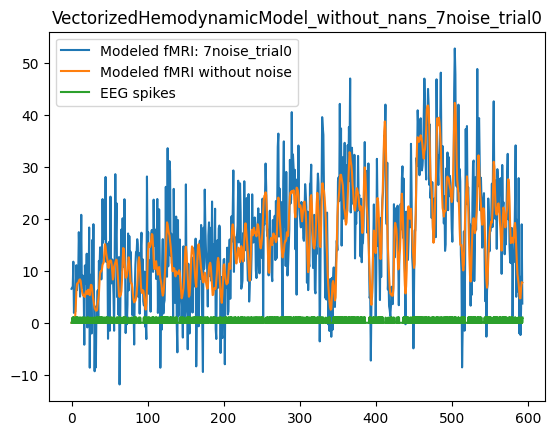

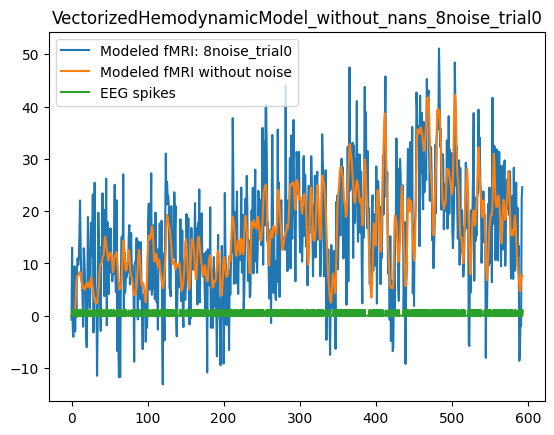

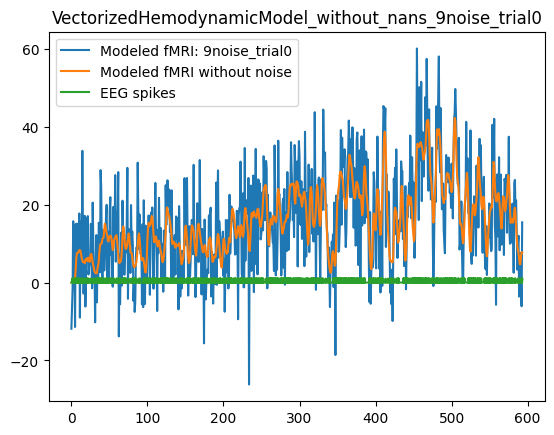

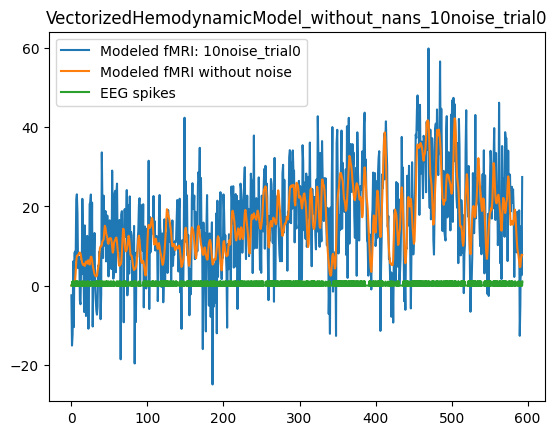

In [6]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [7]:
step_size = 0.05

filename_substring = f'effect_of_step_size_{step_size}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1.25, alpha=2


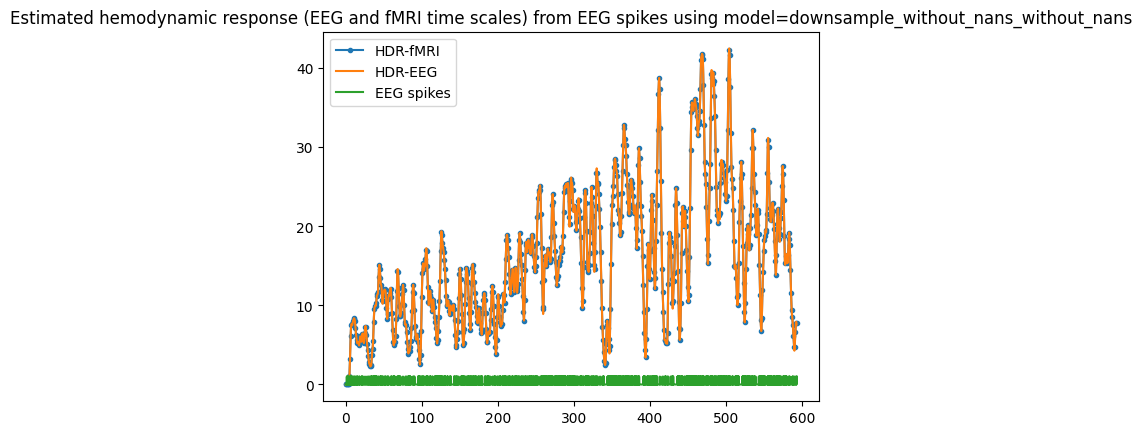

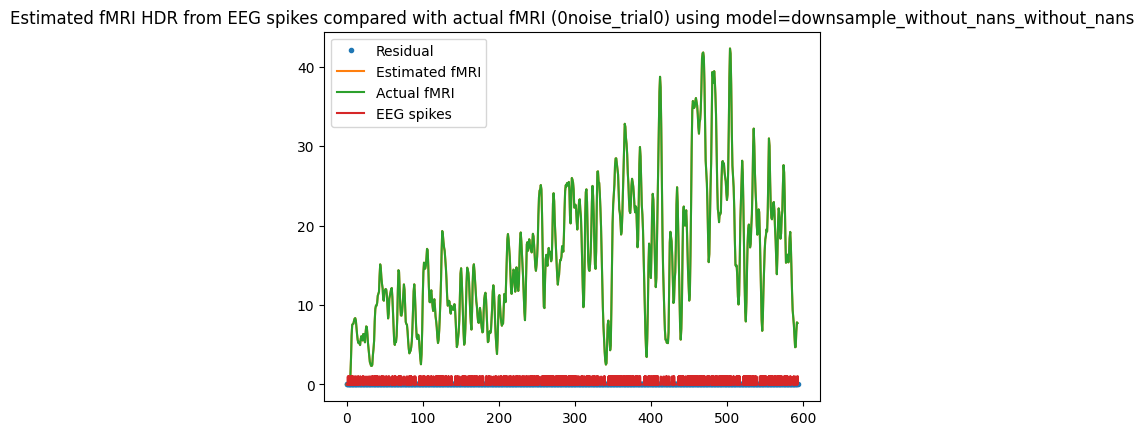

Residual Variance is 0.000000


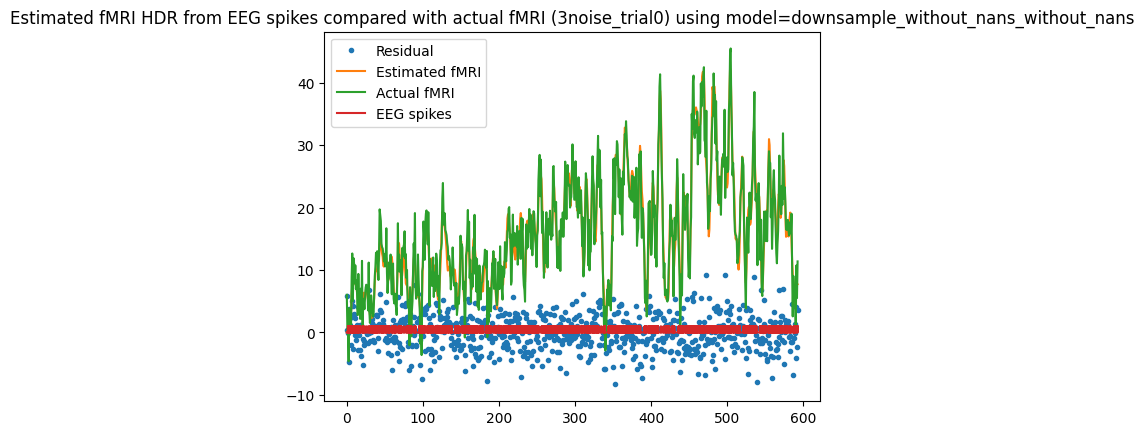

Residual Variance is 8.284503


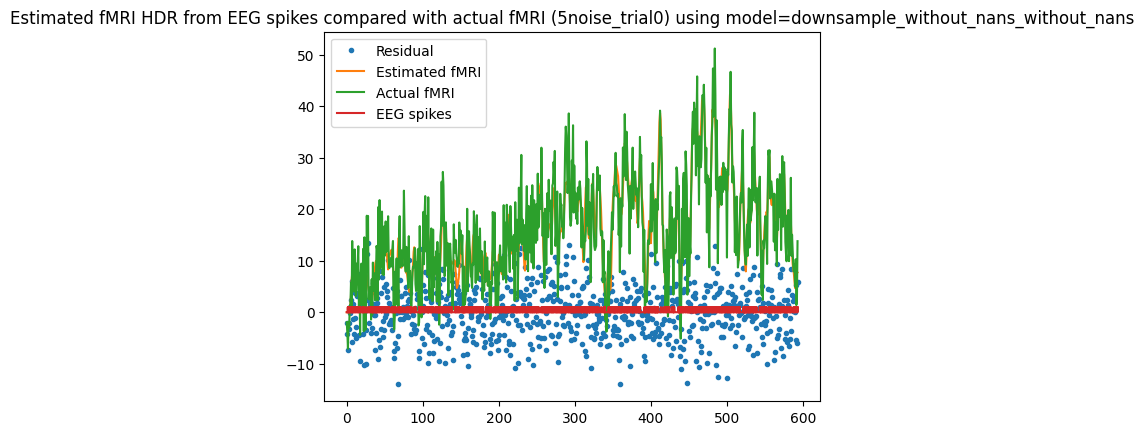

Residual Variance is 24.813096


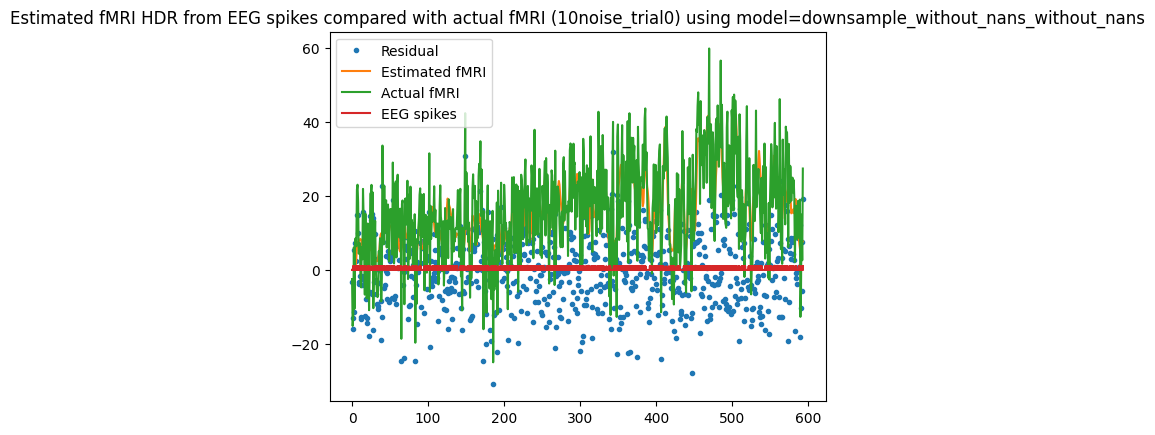

Residual Variance is 97.092607


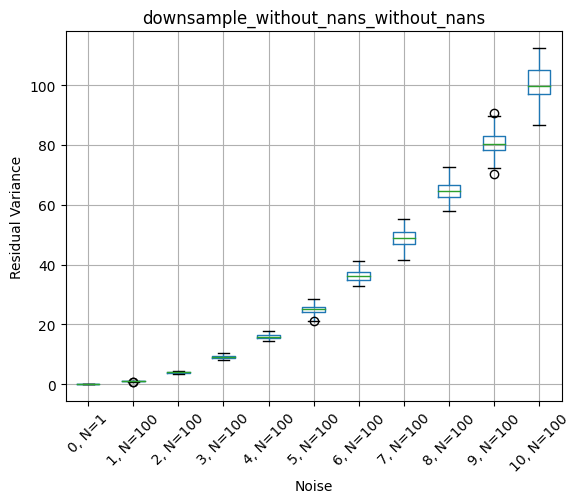

Scoring downsample_without_nans_with_nans delta=2.25, tau=1.25, alpha=2


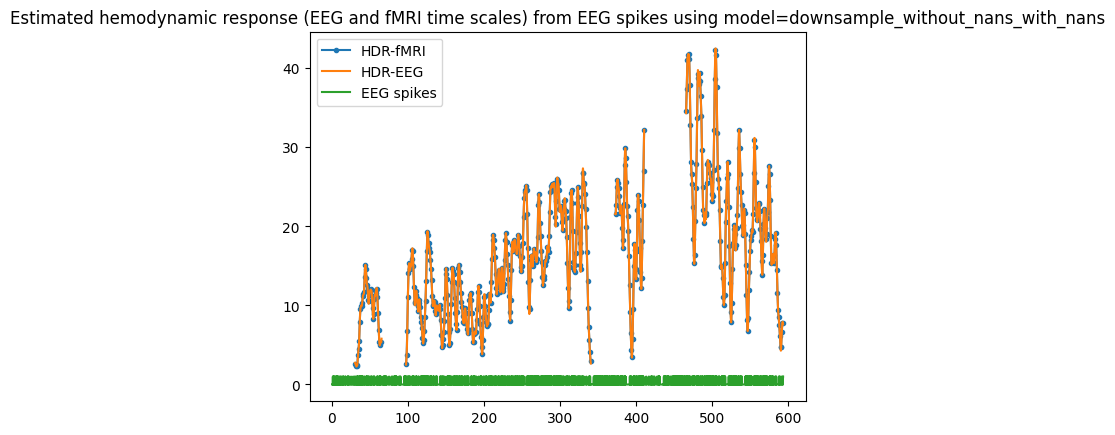

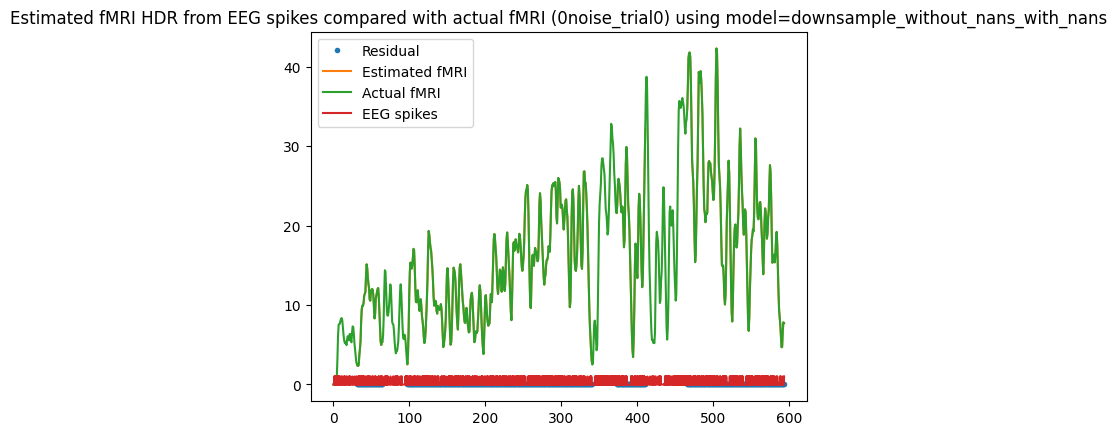

Residual Variance is 0.000000


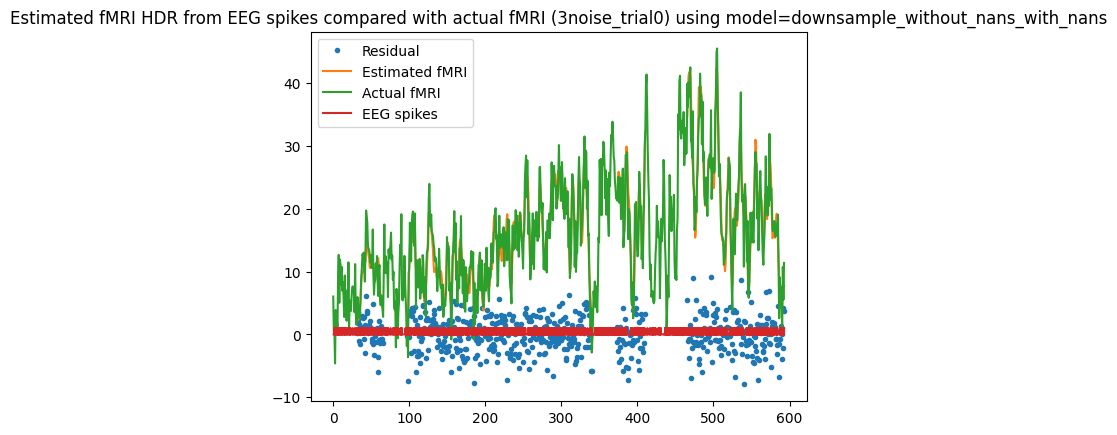

Residual Variance is 8.095618


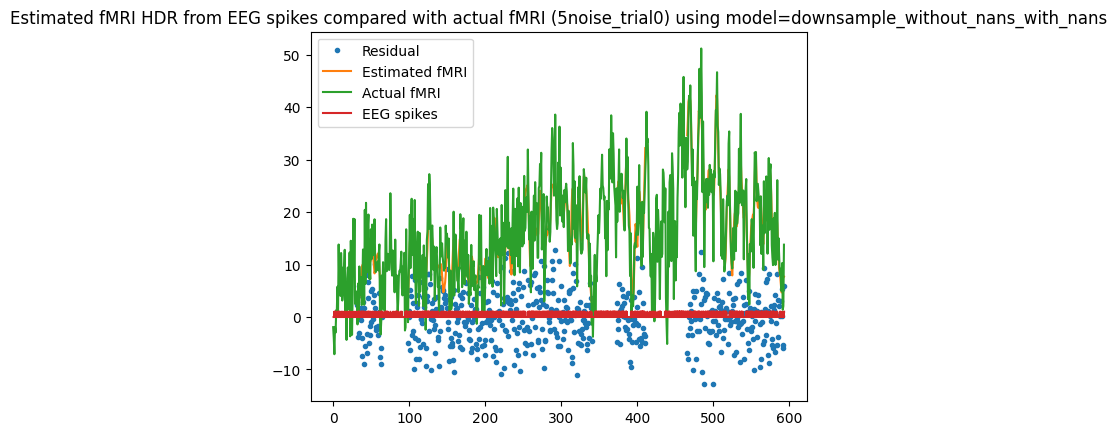

Residual Variance is 23.684262


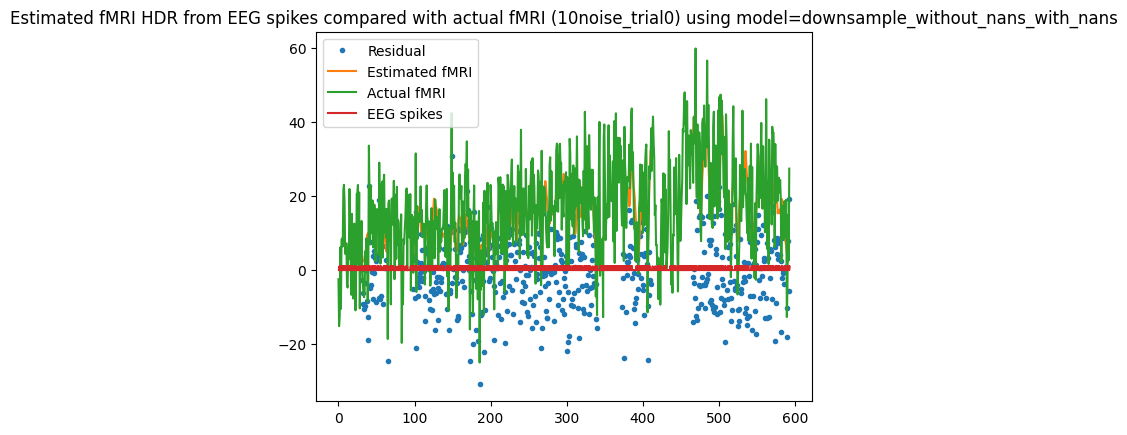

Residual Variance is 93.041728


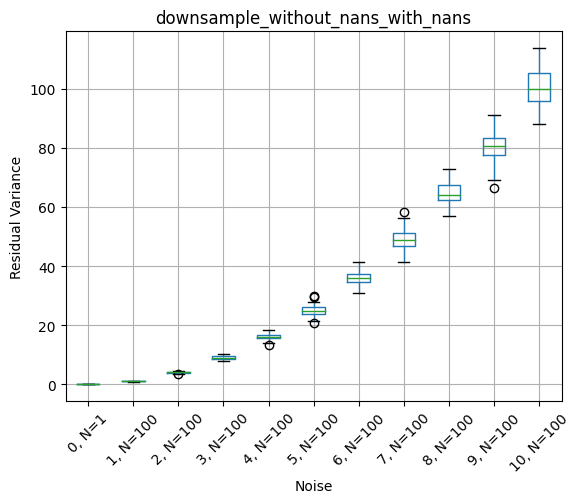

In [8]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False


## Generate/Load the full dataset

In [9]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


Found previously run data. Enter name to reuse or "none" to recalculate.
['effect_of_step_size_0.05_2023-04-11_15:05.csv']
Default (effect_of_step_size_0.05_2023-04-11_15:05.csv)

Loading data from effect_of_step_size_0.05_2023-04-11_15:05.csv...


In [10]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

delta   tau  alpha                            model_name  \
0        1.0  0.75   1.75  downsample_without_nans_without_nans   
1        1.0  0.75   1.75     downsample_without_nans_with_nans   
2        1.0  0.75   1.80  downsample_without_nans_without_nans   
3        1.0  0.75   1.80     downsample_without_nans_with_nans   
4        1.0  0.75   1.85  downsample_without_nans_without_nans   
...      ...   ...    ...                                   ...   
18937    3.0  1.75   2.15     downsample_without_nans_with_nans   
18938    3.0  1.75   2.20  downsample_without_nans_without_nans   
18939    3.0  1.75   2.20     downsample_without_nans_with_nans   
18940    3.0  1.75   2.25  downsample_without_nans_without_nans   
18941    3.0  1.75   2.25     downsample_without_nans_with_nans   

       0noise_trial0  1noise_trial0  2noise_trial0  3noise_trial0  \
0          43.017811      43.979639      45.287322      53.257943   
1          39.269201      39.449126      42.046221      48.841189   
2          42.164123      43.117901      44.424079      52.426156   
3          38.539250      38.726099      41.286567      48.135657   
4          41.301824      42.247902      43.553784      51.584762   
...              ...            ...            ...            ...   
18937      13.906968      14.763581      19.032815      24.228347   
18938      15.975699      17.153943      20.316075      25.616908   
18939      14.600698      15.454245      19.735598      24.974637   
18940      16.757261      17.942584      21.095362      26.453619   
18941      15.288021      16.138437      20.430972      25.713508   

       4noise_trial0  5noise_trial0  ...  1noise_trial99  2noise_trial99  \
0          58.149496      70.363141  ...       44.062550       46.769845   
1          55.354225      66.008132  ...       40.443000       43.443804   
2          57.311775      69.521774  ...       43.196794       45.934370   
3          54.630359      65.252777  ...       39.703662       42.714962   
4          56.466301      68.668449  ...       42.322684       45.090291   
...              ...            ...  ...             ...             ...   
18937      30.417726      41.909294  ...       14.910526       18.213338   
18938      32.136393      42.861649  ...       17.052396       19.431008   
18939      31.123607      42.627040  ...       15.602169       18.915501   
18940      32.929181      43.667953  ...       17.832891       20.201463   
18941      31.824082      43.336023  ...       16.287552       19.610570   

       3noise_trial99  4noise_trial99  5noise_trial99  6noise_trial99  \
0           51.682316       58.132770       65.205541       76.965736   
1           48.897338       55.950171       61.116186       73.705882   
2           50.899076       57.215468       64.338023       76.053745   
3           48.222930       55.123374       60.384659       72.899779   
4           50.107342       56.293130       63.462116       75.135105   
...               ...             ...             ...             ...   
18937       21.693902       30.924905       37.312637       50.461484   
18938       23.384645       31.950505       38.975842       51.102705   
18939       22.341524       31.558393       37.956033       51.191499   
18940       24.100747       32.674186       39.722695       51.885509   
18941       22.985474       32.185187       38.593482       51.912134   

       7noise_trial99  8noise_trial99  9noise_trial99  10noise_trial99  
0           81.919785      104.134211      126.116679       136.081348  
1           77.985425      104.830275      125.280216       129.540377  
2           81.225295      103.243977      125.210537       135.275806  
3           77.378775      103.940981      124.474327       128.895266  
4           80.523547      102.349170      124.293175       134.467137  
...               ...             ...             ...              ...  
18937       54.462995       84.272384       89.412376       105.795674  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 2.9586856467841044e-29; at
       delta   tau  alpha
11780   2.25  1.25    2.0


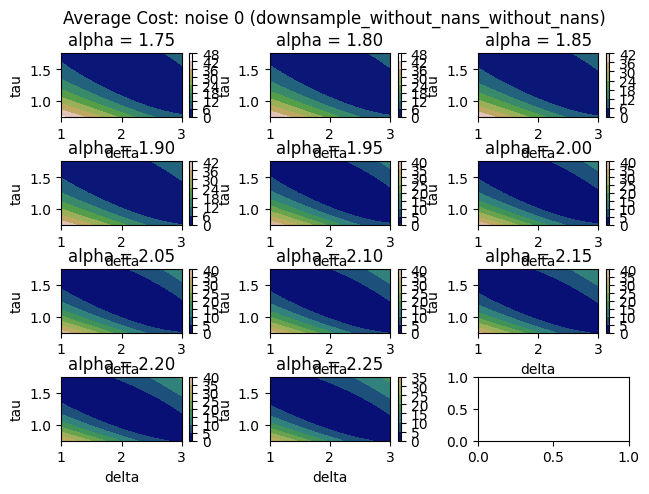

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              43.017811             
2                                              42.164123             
4                                              41.301824             
6                                              40.431612             
8                                              39.554209             
...                                                  ...             
18932                                          13.612216             
18934                                          14.401818             
18936                                          15.190117             
18938                                          15.975699             
18940                                          16.757261             

[9471 rows x 4 columns]

In [11]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [12]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0   2.25  1.25    2.0

### Local Minima Analysis

In [13]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.352722e-03   2.20  1.20   2.15
1      0         0  2.958686e-29   2.25  1.25   2.00
2      0         0  5.338736e-03   2.30  1.30   1.85

In [14]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [15]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [20]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 3.3110047089750986e-29; at
       delta   tau  alpha
11781   2.25  1.25    2.0


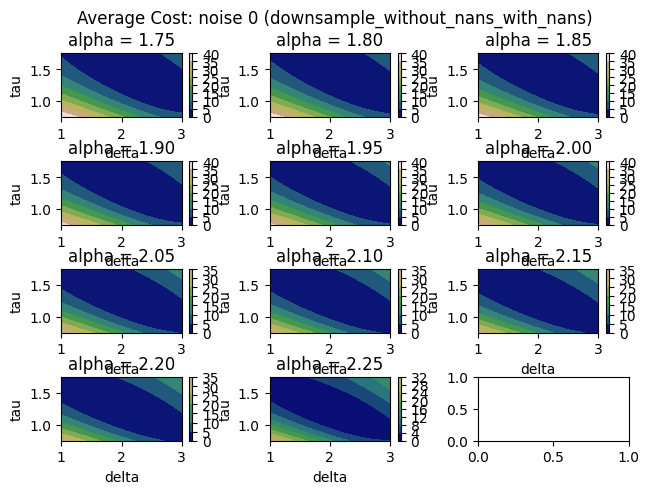

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              39.269201          
3                                              38.539250          
5                                              37.799030          
7                                              37.049107          
9                                              36.290082          
...                                                  ...          
18933                                          12.505089          
18935                                          13.208002          
18937                                          13.906968          
18939                                          14.600698          
18941                                          15.288021          

[9471 rows x 4 columns]

In [21]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [22]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0   2.25  1.25    2.0

### Local Minima Analysis

In [23]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.288068e-03   2.20  1.20   2.15
1      0         0  3.311005e-29   2.25  1.25   2.00
2      0         0  5.361413e-03   2.30  1.30   1.85

In [24]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [25]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [30]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.0003300234536332; at
       delta   tau  alpha
11780   2.25  1.25    2.0


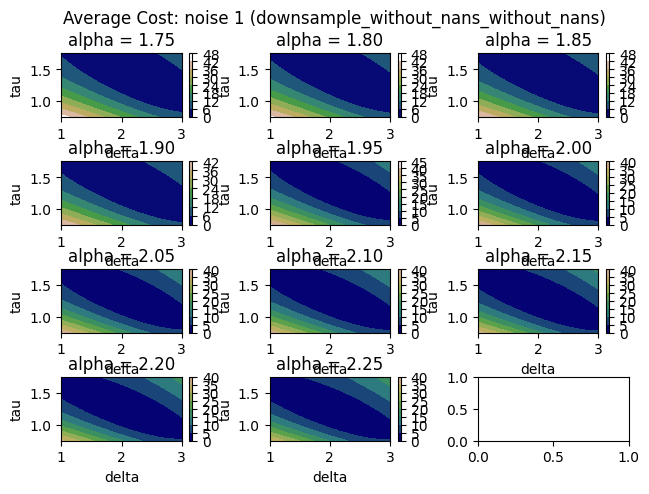

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 3.9829832664568436; at
       delta   tau  alpha
11780   2.25  1.25    2.0


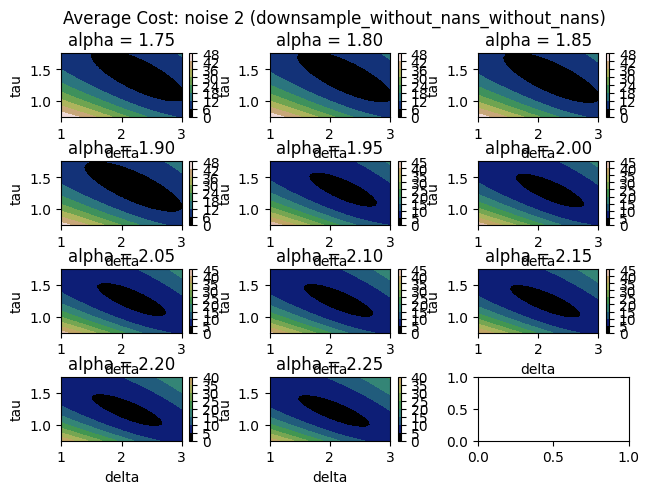

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 9.04671973736411; at
       delta   tau  alpha
11780   2.25  1.25    2.0


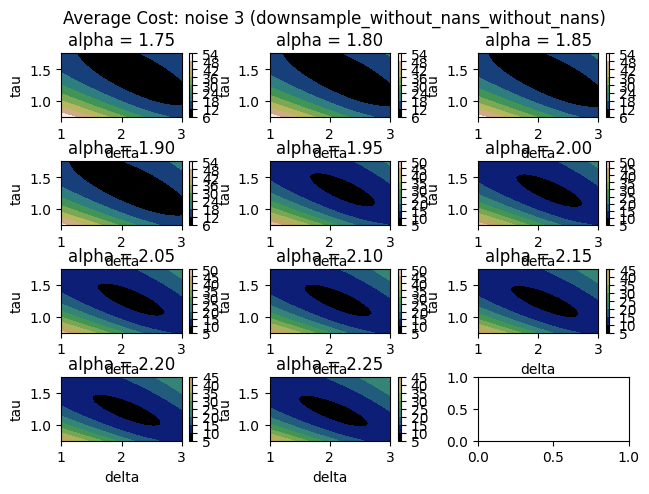

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.045405314171248; at
       delta   tau  alpha
11780   2.25  1.25    2.0


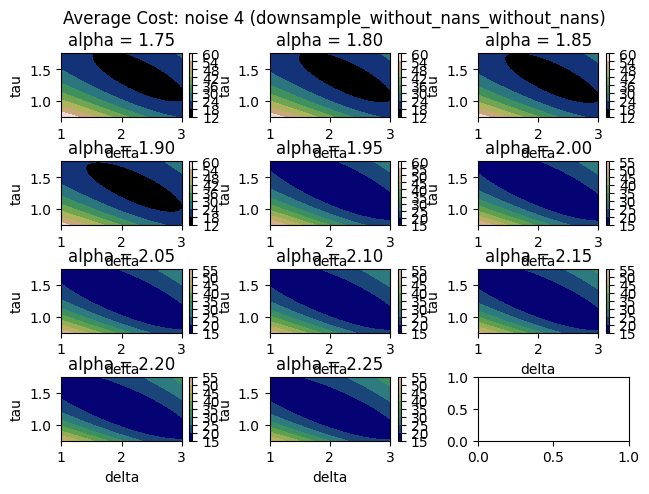

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.971575612608447; at
       delta   tau  alpha
12240    2.3  1.25   1.95


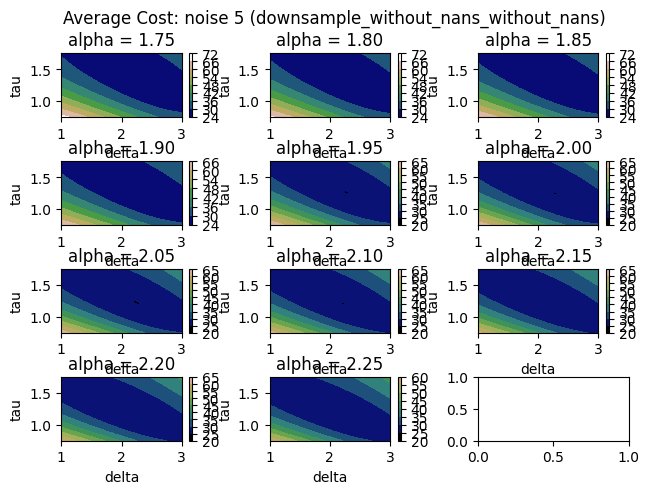

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.27032824628829; at
       delta   tau  alpha
11780   2.25  1.25    2.0


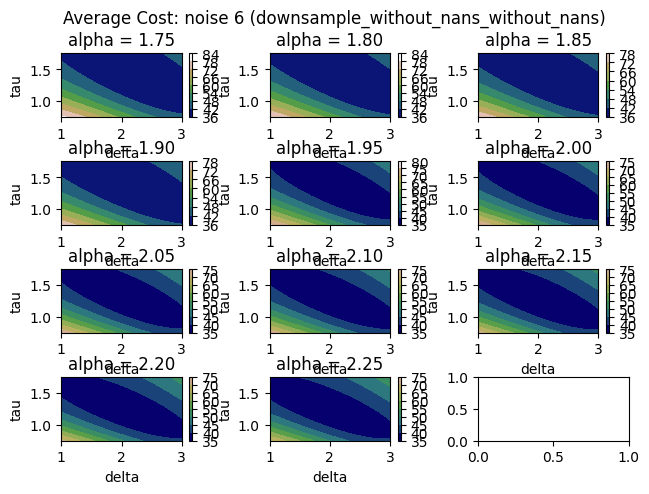

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.85633907491257; at
       delta   tau  alpha
12240    2.3  1.25   1.95


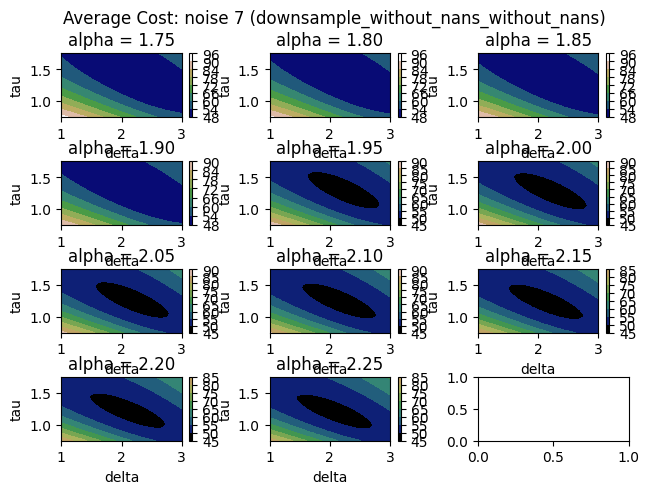

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 63.459000556135315; at
       delta   tau  alpha
11780   2.25  1.25    2.0


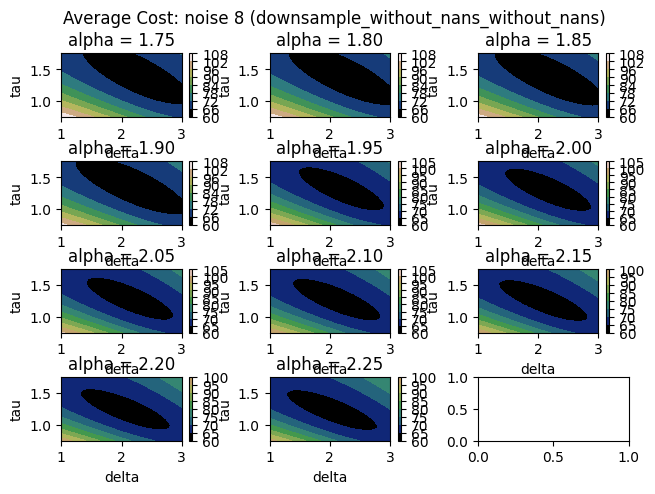

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 80.98879390443585; at
       delta  tau  alpha
12258    2.3  1.3   1.85


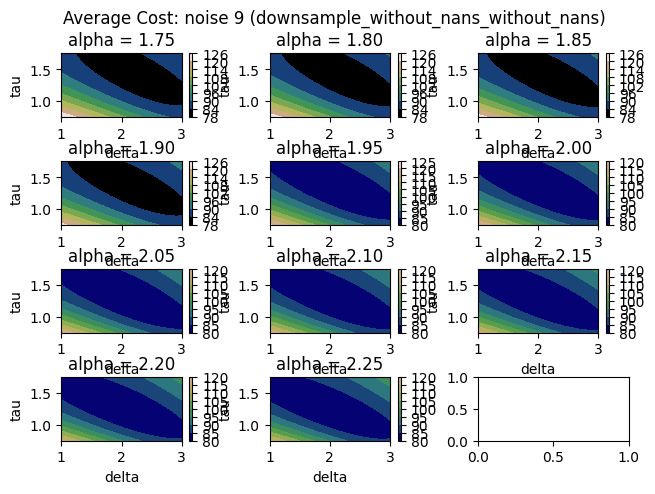

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 100.2143958184004; at
       delta  tau  alpha
10382    2.1  1.2   2.25


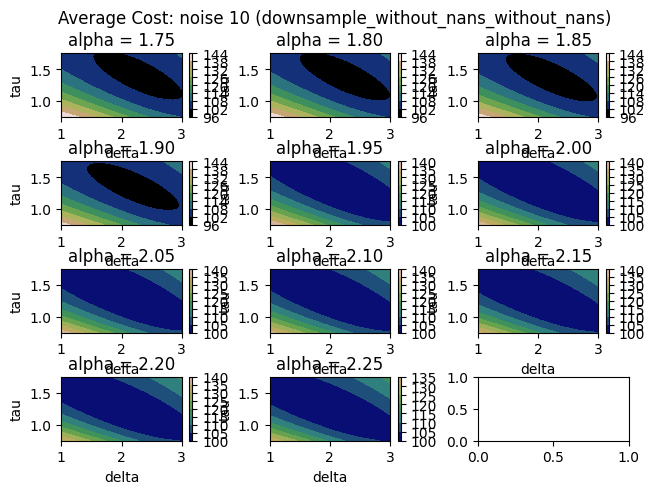

In [31]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

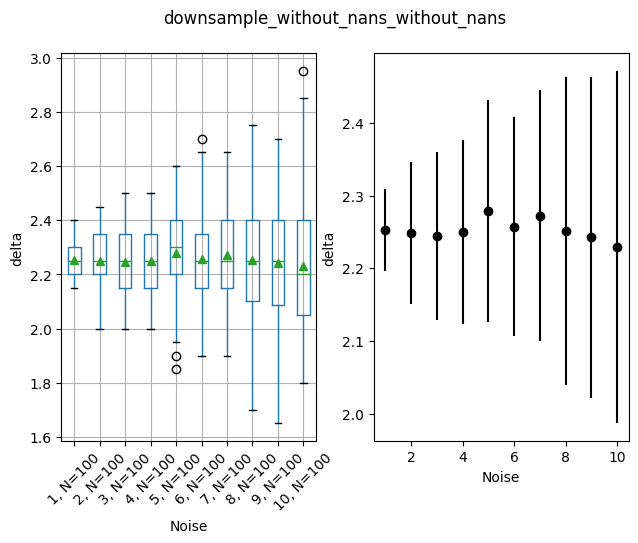

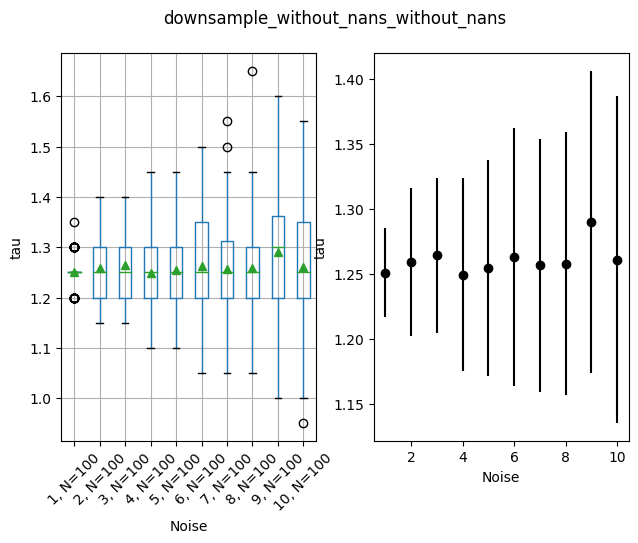

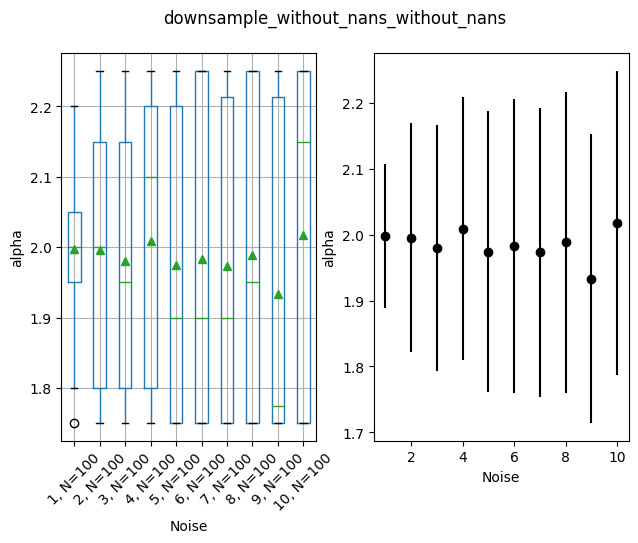

In [32]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.9954872165087939; at
       delta   tau  alpha
11781   2.25  1.25    2.0


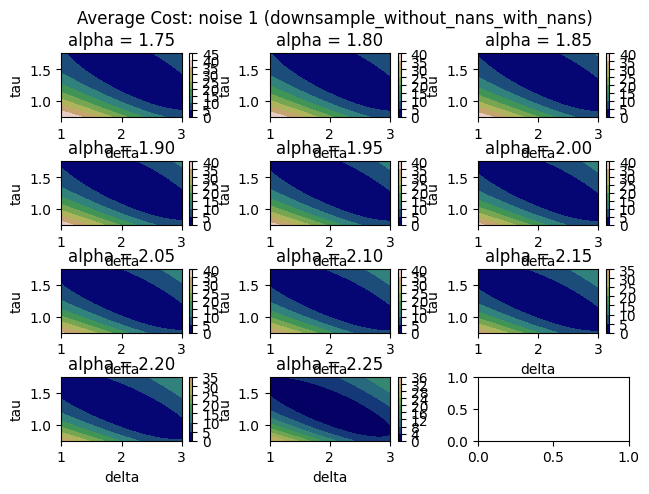

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 3.984670267695488; at
       delta   tau  alpha
11781   2.25  1.25    2.0


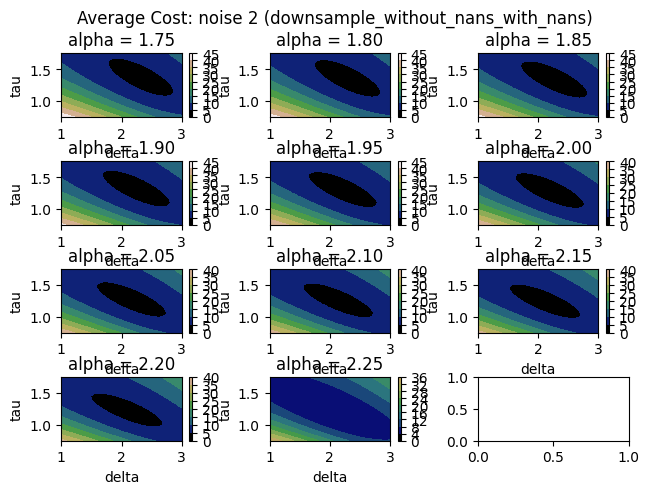

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.061352450904897; at
       delta   tau  alpha
11781   2.25  1.25    2.0


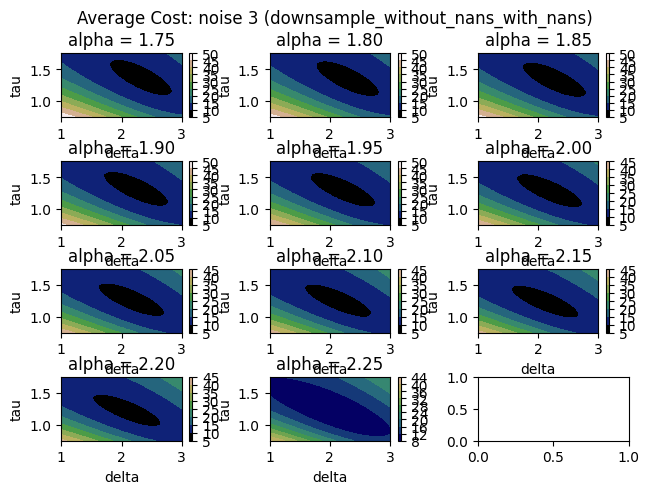

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.120646546337298; at
       delta   tau  alpha
11781   2.25  1.25    2.0


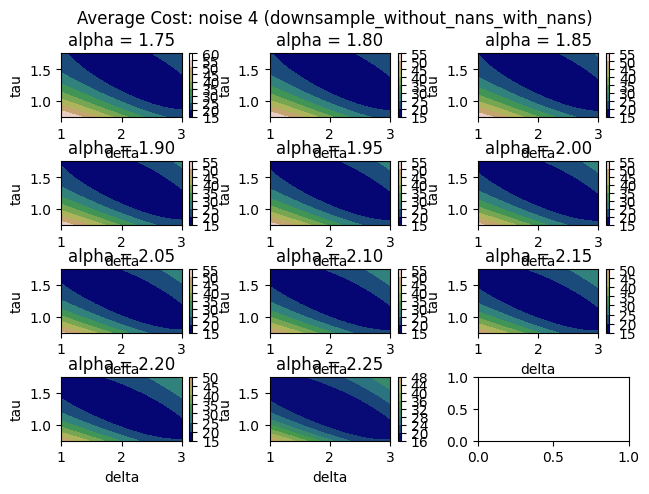

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 24.96058225037824; at
       delta   tau  alpha
12241    2.3  1.25   1.95


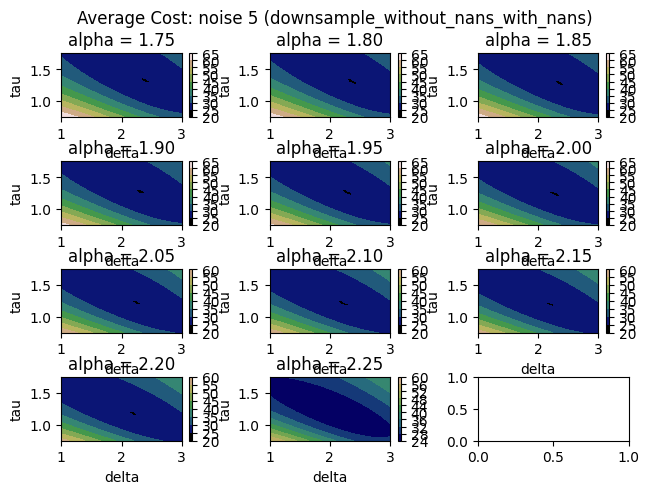

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.270233530315956; at
       delta  tau  alpha
11303    2.2  1.2   2.15


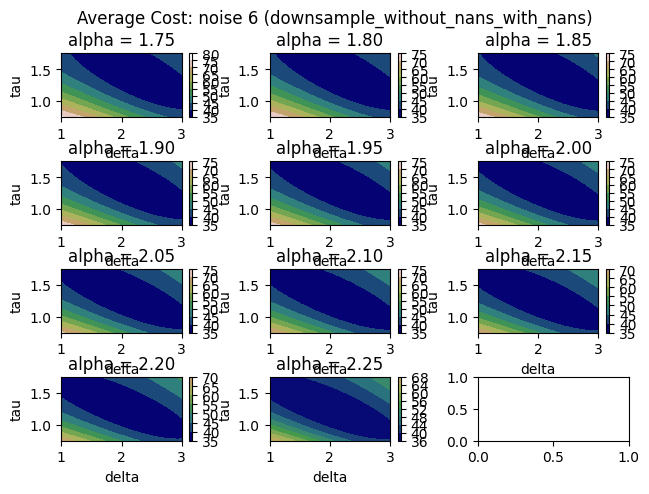

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.71606157334747; at
       delta   tau  alpha
12241    2.3  1.25   1.95


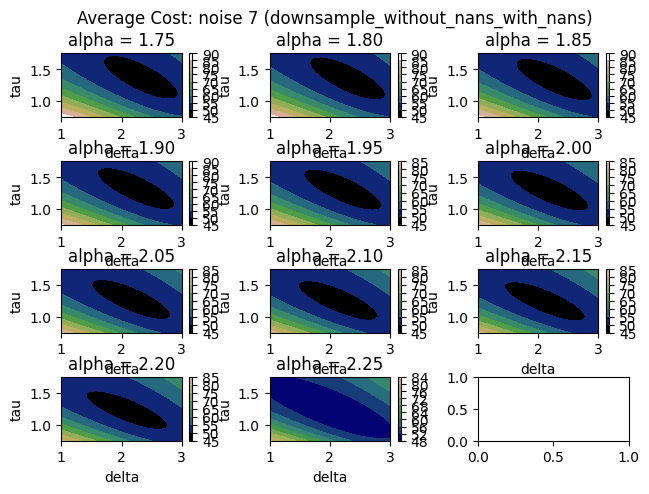

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.59210704199485; at
       delta   tau  alpha
11321    2.2  1.25   2.05


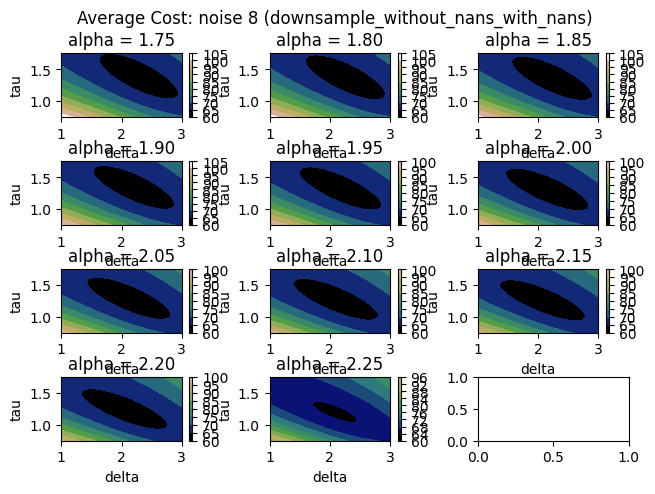

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.77082528533452; at
       delta  tau  alpha
11799   2.25  1.3    1.9


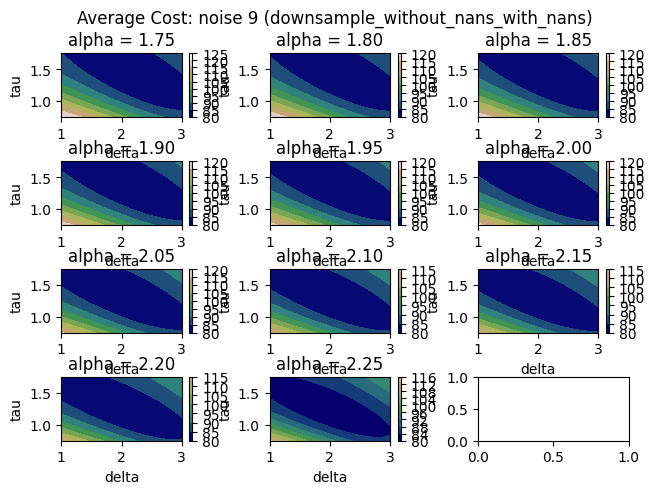

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 100.39063595170836; at
       delta  tau  alpha
10383    2.1  1.2   2.25


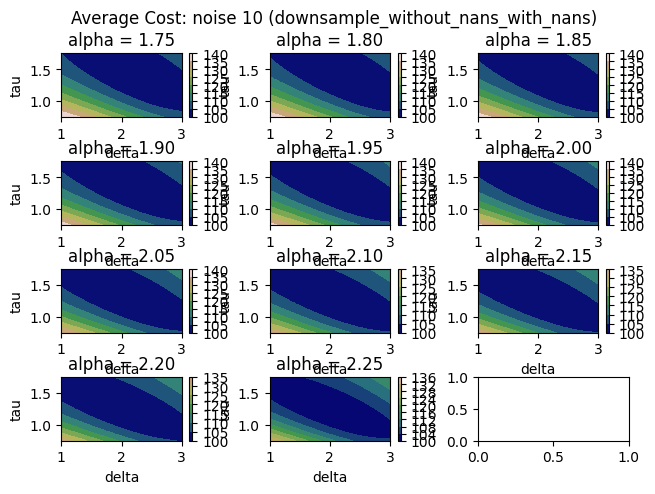

In [33]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


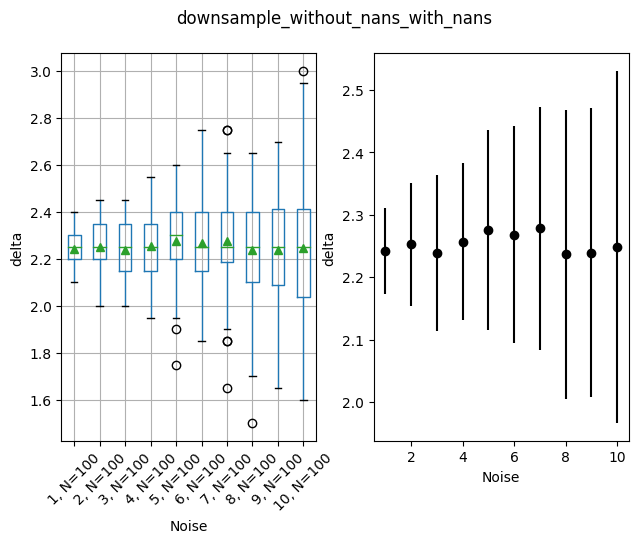

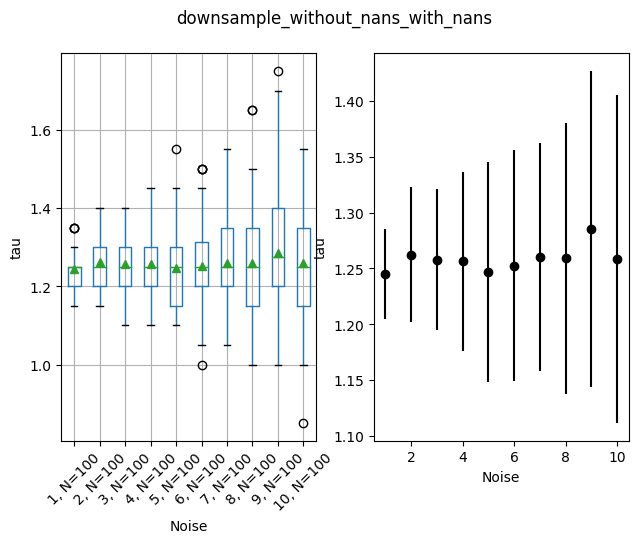

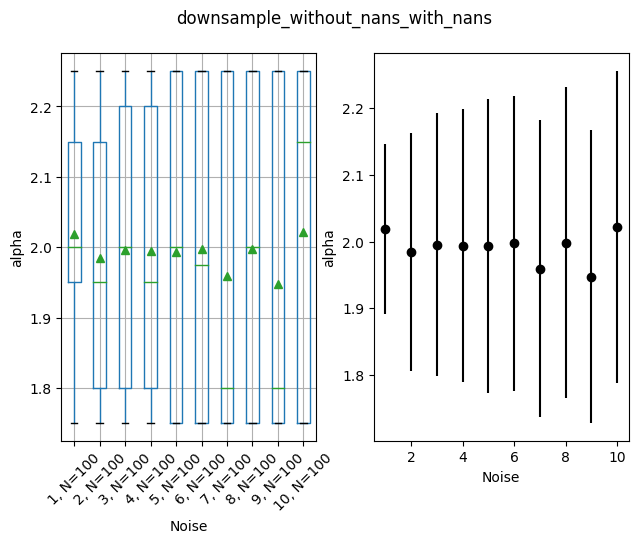

In [34]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [35]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [36]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [37]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost  delta   tau  alpha
0         1         9    1.072268   2.10  1.20   2.20
1         1        42    1.084970   2.10  1.20   2.20
2         1        59    1.083703   2.10  1.20   2.20
3         1        93    1.023239   2.10  1.20   2.20
4         1         3    1.003301   2.10  1.20   2.25
...     ...       ...         ...    ...   ...    ...
2662     10        36  105.518061   2.85  0.90   2.20
2663     10        23  100.493049   2.85  1.05   1.75
2664     10        36  105.521747   2.90  0.90   2.10
2665     10        36  105.512992   2.95  0.95   1.95
2666     10        36  105.520317   3.00  1.00   1.75

[2667 rows x 6 columns]

In [38]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.31  0.544857  2.0  3.0  3.0  4.0  4.0
2                      100.0  3.44  0.574192  2.0  3.0  3.0  4.0  4.0
3                      100.0  3.04  0.875249  1.0  3.0  3.0  4.0  4.0
4                      100.0  2.91  1.015983  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.73  1.117853  1.0  2.0  3.0  4.0  4.0
6                      100.0  2.58  1.199158  1.0  1.0  3.0  4.0  4.0
7                      100.0  2.38  1.098943  1.0  1.0  2.0  3.0  4.0
8                      100.0  2.14  1.172238  1.0  1.0  2.0  3.0  4.0
9                      100.0  2.08  1.169304  1.0  1.0  2.0  3.0  4.0
10                     100.0  2.06  1.108461  1.0  1.0  2.0  3.0  6.0

#### Local minima at edges

In [39]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost  delta  tau  alpha
2666     10        36  105.520317    3.0  1.0   1.75

In [41]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [43]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost  delta   tau  alpha
294       1         2    0.928413   2.35  1.35   1.75
295       1         3    1.006656   2.35  1.35   1.75
296       1         9    1.075199   2.35  1.35   1.75
297       1        10    1.050080   2.35  1.35   1.75
298       1        14    1.044556   2.35  1.35   1.75
...     ...       ...         ...    ...   ...    ...
2655     10        45   89.263706   2.65  1.20   1.75
2657     10        43  100.589576   2.65  1.30   1.75
2660     10        43  100.595580   2.75  1.25   1.75
2663     10        23  100.493049   2.85  1.05   1.75
2666     10        36  105.520317   3.00  1.00   1.75

[426 rows x 6 columns]

In [44]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        29      1  2.3500000000000014   29    29      1  1.3500000000000003   
10       40     18   2.250000000000001    5    40     11  1.3500000000000003   
2        38      5  2.3500000000000014   20    38      3  1.3500000000000003   
3        32      7  2.3500000000000014   16    32      3  1.3500000000000003   
4        35      7   2.400000000000001   10    35      5  1.3500000000000003   
5        49      9  2.3500000000000014   10    49      5  1.3000000000000005   
6        47     14   2.200000000000001    7    47      7  1.3500000000000003   
7        50     14   2.450000000000001   12    50      8  1.3500000000000003   
8        50     14   2.450000000000001    8    50      8  1.3000000000000005   
9        56     14   2.400000000000001    9    56      9  1.3500000000000003   

            
      freq  
noise       
1       29  
10       8  
2       29  
3       20  
4       15  
5       17  
6       14  
7       16  
8       11  
9       11

In [45]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost  delta   tau  alpha
4         1         3    1.003301   2.10  1.20   2.25
5         1        10    1.050983   2.10  1.20   2.25
6         1        16    0.939482   2.10  1.20   2.25
7         1        46    1.028802   2.10  1.20   2.25
8         1        51    1.030284   2.10  1.20   2.25
...     ...       ...         ...    ...   ...    ...
2596     10        59   92.217515   2.35  1.05   2.25
2599     10        29   98.770916   2.35  1.20   2.25
2611     10        22  102.620032   2.40  1.05   2.25
2612     10        55   90.297714   2.40  1.10   2.25
2645     10         8   96.069973   2.60  1.00   2.25

[380 rows x 6 columns]

In [46]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        12      3   2.100000000000001    7    12      2  1.2000000000000004   
10       54     16   2.150000000000001   11    54      8  1.2500000000000004   
2        37      5   2.100000000000001   17    37      2  1.2000000000000004   
3        36      7   2.100000000000001   13    36      3  1.2000000000000004   
4        43      7   2.200000000000001   13    43      4  1.2000000000000004   
5        39      9   2.150000000000001   12    39      4  1.1500000000000004   
6        41     11   2.200000000000001    7    41      5  1.2000000000000004   
7        41     11  2.0500000000000007    6    41      6  1.1500000000000004   
8        41     16   2.150000000000001    6    41      8  1.2000000000000004   
9        36     15   2.150000000000001    5    36      9  1.2000000000000004   

            
      freq  
noise       
1        7  
10      14  
2       24  
3       22  
4       20  
5       17  
6       17  
7       13  
8       10  
9       11

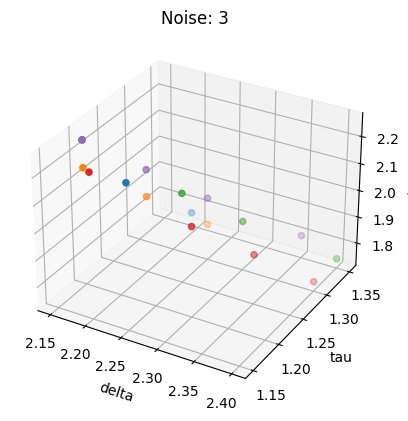

In [47]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

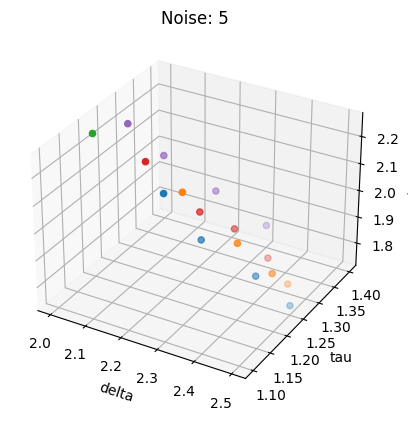

In [48]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

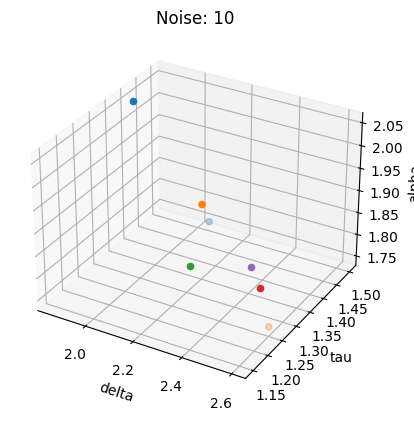

In [49]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [50]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [51]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [52]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost  delta   tau  alpha
0         1        37    0.990483    2.1  1.20   2.20
1         1        42    1.093098    2.1  1.20   2.20
2         1        50    0.969117    2.1  1.20   2.20
3         1        59    1.055507    2.1  1.20   2.20
4         1        93    1.002711    2.1  1.20   2.20
...     ...       ...         ...    ...   ...    ...
2534     10        36  102.102928    3.0  0.90   2.05
2535     10        36  102.121542    3.0  0.95   1.90
2536     10        14   96.233135    3.0  0.95   2.25
2537     10        14   96.221485    3.0  1.00   2.10
2538     10        14   96.233724    3.0  1.05   2.00

[2539 rows x 6 columns]

In [53]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.36  0.522620  2.0  3.0  3.0  4.0  4.0
2                      100.0  3.45  0.625631  2.0  3.0  4.0  4.0  4.0
3                      100.0  3.11  0.952350  1.0  3.0  3.0  4.0  4.0
4                      100.0  2.61  1.136137  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.41  1.129002  1.0  1.0  2.5  3.0  4.0
6                      100.0  2.36  1.105724  1.0  1.0  2.0  3.0  4.0
7                      100.0  2.12  1.183045  1.0  1.0  2.0  3.0  5.0
8                      100.0  1.86  1.044659  1.0  1.0  1.0  3.0  4.0
9                      100.0  2.11  1.171160  1.0  1.0  2.0  3.0  5.0
10                     100.0  2.00  1.163415  1.0  1.0  2.0  3.0  7.0

#### Local minima at edges

In [54]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost  delta   tau  alpha
2534     10        36  102.102928    3.0  0.90   2.05
2535     10        36  102.121542    3.0  0.95   1.90
2536     10        14   96.233135    3.0  0.95   2.25
2537     10        14   96.221485    3.0  1.00   2.10
2538     10        14   96.233724    3.0  1.05   2.00

In [56]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration       cost  delta   tau  alpha
2129      9         9  84.318603    1.7  1.75    1.9

In [58]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost  delta   tau  alpha
258       1        42    1.101205   2.30  1.35   1.75
295       1         9    1.088324   2.35  1.35   1.75
296       1        13    1.014441   2.35  1.35   1.75
297       1        16    0.992651   2.35  1.35   1.75
298       1        29    0.953789   2.35  1.35   1.75
...     ...       ...         ...    ...   ...    ...
2526     10        24   87.801889   2.75  1.10   1.75
2527     10        20  105.207535   2.75  1.15   1.75
2530     10        72   99.992692   2.75  1.25   1.75
2531     10        23  103.359467   2.80  1.00   1.75
2532     10        78  107.322465   2.80  1.10   1.75

[408 rows x 6 columns]

In [59]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        30      3  2.3500000000000014   27    30      2  1.3500000000000003   
10       44     16   2.250000000000001    5    44     11  1.4000000000000006   
2        34      5  2.3500000000000014   15    34      3  1.3500000000000003   
3        41      6   2.400000000000001   12    41      4  1.3500000000000003   
4        36      8  2.3500000000000014   10    36      5  1.3000000000000005   
5        44      9   2.450000000000001   11    44      7  1.3500000000000003   
6        33     11  2.5000000000000013    6    33      7  1.3500000000000003   
7        49     14   2.250000000000001    6    49      9  1.3000000000000005   
8        45     14   2.400000000000001    8    45     10  1.2500000000000004   
9        52     17   2.200000000000001    7    52     11  1.4000000000000006   

            
      freq  
noise       
1       29  
10       7  
2       22  
3       24  
4       13  
5       14  
6        8  
7       13  
8       10  
9       10

In [60]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost  delta   tau  alpha
5         1         3    1.025763   2.10  1.20   2.25
6         1        10    1.075172   2.10  1.20   2.25
7         1        14    1.078644   2.10  1.20   2.25
8         1        16    0.980157   2.10  1.20   2.25
9         1        36    0.976916   2.10  1.20   2.25
...     ...       ...         ...    ...   ...    ...
2514     10        22  100.081216   2.60  1.00   2.25
2515     10        76   92.820348   2.60  1.05   2.25
2522     10        14   96.252267   2.70  1.05   2.25
2533     10        36  102.099195   2.95  0.85   2.25
2536     10        14   96.233135   3.00  0.95   2.25

[418 rows x 6 columns]

In [61]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        15      3   2.100000000000001    7    15      2  1.1500000000000004   
10       58     21  1.9500000000000008    7    58     12  1.2500000000000004   
2        44      6   2.150000000000001   14    44      2  1.2000000000000004   
3        45      8   2.150000000000001   11    45      4  1.2000000000000004   
4        42      8   2.150000000000001   11    42      4  1.2000000000000004   
5        41     11   2.250000000000001   12    41      5  1.1500000000000004   
6        46     11   2.250000000000001    8    46      6  1.2000000000000004   
7        40     14   2.150000000000001    5    40      7  1.2000000000000004   
8        47     17   2.150000000000001   10    47      7  1.2000000000000004   
9        40     13  1.9500000000000008    5    40      9  1.2000000000000004   

            
      freq  
noise       
1        8  
10      12  
2       23  
3       21  
4       18  
5       19  
6       13  
7       17  
8        9  
9       11

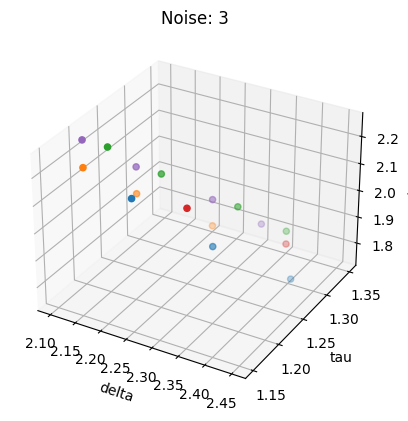

In [62]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

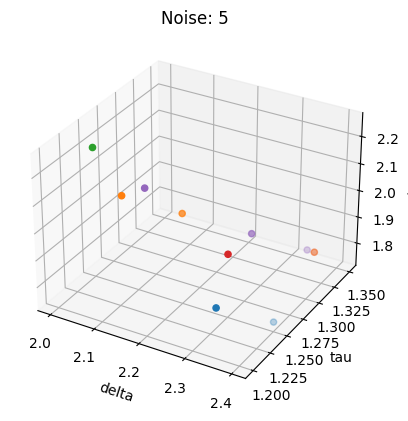

In [63]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

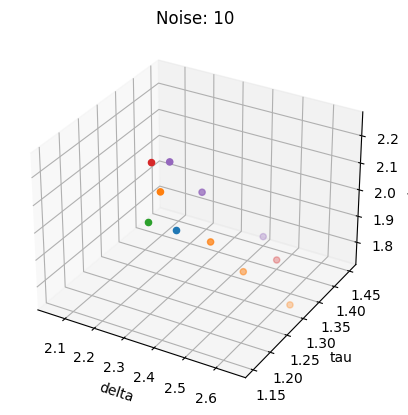

In [64]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()